In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!pip install -r /content/drive/MyDrive/raptor/requirements.txt

In [ ]:
!pip install -U langchain-community

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = 'my key'


# 第一部分
实现了从包含文本和图像的PDF文档中提取内容，并将其存储在Chroma向量数据库中的整个流程。

主要功能概述

加载PDF文档：从指定路径加载PDF文件，并提取每一页的文本和图像信息。

递归分割文本：将长文本递归地分割成更小的文本块（chunks），确保每个文本块在句子的结尾处分割。

构建树状结构：每个分割后的文本块被组织成树状结构，以保持文本的逻辑结构。

存储到Chroma数据库：将分割后的文本块存储在Chroma向量数据库中，供以后检索和分析使用。

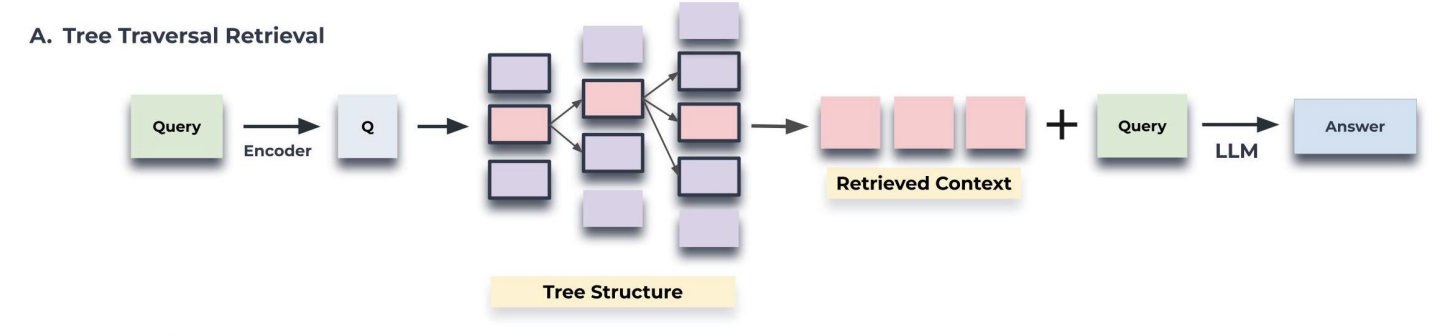

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores.chroma import Chroma
import os
import shutil

CHROMA_PATH = "chroma"
DATA_PATH = "/content/drive/MyDrive/raptor/baichuan.pdf"
MAX_CHUNK_SIZE = 300
OVERLAP_SIZE = 100


class ChunkNode:
    def __init__(self, document: Document, children=None):
        self.document = document
        self.children = children or []


def main():
    generate_data_store()


def generate_data_store():
    documents = load_documents()
    root_nodes = split_text(documents)
    save_to_chroma(root_nodes)


def load_documents():
    loader = PyPDFLoader(DATA_PATH)
    documents = loader.load()
    return documents


def split_text(documents: list[Document]):
    root_nodes = []
    for document in documents:
        text = document.page_content
        root_node = split_text_recursive(text, document.metadata)
        root_nodes.append(root_node)
    return root_nodes


def split_text_recursive(text: str, metadata: dict) -> ChunkNode:
    if len(text) <= MAX_CHUNK_SIZE:
        return ChunkNode(Document(page_content=text, metadata=metadata))

    chunks = []
    start_index = 0
    while start_index < len(text):
        end_index = start_index + MAX_CHUNK_SIZE
        # Find the end of the current sentence
        while end_index < len(text) and text[end_index] not in ['.', '!', '?']:
            end_index += 1
        # If end of sentence not found, take the next MAX_CHUNK_SIZE characters
        if end_index == len(text):
            end_index = start_index + MAX_CHUNK_SIZE
        # Extract the chunk
        chunk_text = text[start_index:end_index].strip()
        if chunk_text:  # Ensure non-empty chunks
            chunk_node = split_text_recursive(chunk_text, metadata)
            chunks.append(chunk_node)
        start_index = end_index

    return ChunkNode(Document(page_content="", metadata=metadata), chunks)



def save_to_chroma(root_nodes: list[ChunkNode]):
    # Clear out the database first.
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)

    # Flatten the tree structure to a list of documents
    flat_chunks = flatten_tree(root_nodes)

    # Create a new DB from the documents.
    db = Chroma.from_documents(
        flat_chunks, OpenAIEmbeddings(), persist_directory=CHROMA_PATH
    )
    db.persist()
    print(f"Saved {len(flat_chunks)} chunks to {CHROMA_PATH}.")


def flatten_tree(root_nodes: list[ChunkNode]) -> list[Document]:
    flat_chunks = []

    def traverse(node):
        flat_chunks.append(node.document)
        for child in node.children:
            traverse(child)

    for root_node in root_nodes:
        traverse(root_node)

    return flat_chunks


if __name__ == "__main__":
    main()

Saved 724 chunks to chroma.


In [ ]:
!pip install -U langchain_openai

In [ ]:
from langchain.vectorstores.chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import numpy as np

CHROMA_PATH = "chroma"
PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

def main():
    # 预先输入的问题列表
    queries = [
        "What are the two main configurations of Baichuan 2 models?",
        "How many tokens were used to train the Baichuan 2 models?",
        "In which areas does Baichuan 2 outperform other open-source models?"

    ]
    respon = []
    # 加载 Chroma 向量存储
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=OpenAIEmbeddings())

    # 初始化模型
    model = ChatOpenAI()

    for query in queries:
        # 在数据库中搜索与查询相关的文档
        results = db.similarity_search_with_relevance_scores(query, k=3)
        if len(results) == 0 or results[0][1] < 0.7:
            print(f"Unable to find matching results for query: {query}")
            continue

        # 提取上下文并生成响应
        context_tree = [doc for doc, _score in results]
        response_text, context_text = generate_response(context_tree, query, model)

        sources = [doc.metadata.get("source", None) for doc in context_tree]
        # 打印结果
        respon.append(response_text)
    for i in range(3):
        print(respon[i])

def expand_context(context_tree):
    # 展开上下文以包含更多信息
    expanded_context = "\n\n---\n\n".join([doc.page_content.strip() for doc in context_tree])
    return expanded_context

def generate_response(context_tree, query, model):
    # 使用上下文生成响应
    expanded_context = expand_context(context_tree)

    # 创建提示模板并生成响应
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=expanded_context, question=query)

    max_response_length = 500  # 可以根据需要调整
    response_text = model.predict(prompt, max_tokens=max_response_length)

    return response_text, expanded_context

if __name__ == "__main__":
    main()


The two main configurations of Baichuan 2 models are Baichuan 2-7B with 7 billion parameters and Baichuan 2-13B with 13 billion parameters.
The Baichuan 2 models were trained on 2.6 trillion tokens.
Baichuan 2 outperforms other open-source models in medical and legal domain tasks.
